# RNN, LSTM, GRU for Trading

## Importing the required packages

In [18]:
import os
import math
import seaborn as sns
import datetime
import numpy as np
import pandas as pd
import sklearn
import sklearn.preprocessing
import matplotlib.pyplot as plt
import tensorflow as tf

## Env setup

In [19]:
# This is needed to display the images.
%matplotlib inline
sns.set()

## Importing the Dataset
The dataset used is the daily OHLC data for the stock of "RELIANCE" trading on NSE for the time period from 1st January 1996 to 30th Sep 2018.

In [3]:
dataset = pd.read_csv('RELIANCE.NS.csv', index_col = 0)
dataset.head() # Have a quick look on the dataset

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-01-01,16.009800,16.095699,15.904300,16.0683,2.426239,47600787.0
1996-01-02,16.029301,16.107401,15.826200,15.9434,2.407380,77143764.0
1996-01-03,16.205000,16.943001,16.029301,16.0644,2.425650,95695836.0
1996-01-04,15.912100,15.962900,15.701300,15.9160,2.403243,99159504.0
1996-01-05,15.853600,15.853600,15.670000,15.8067,2.386739,76213503.0


Here we only want the open, high, low and close data from this dataset.

In [4]:
df_stock = dataset.copy()
df_stock = df_stock.dropna() # Remove missing values from the dataset
df_stock = df_stock[['Open', 'High', 'Low', 'Close']] # Take only OHLC data
df_stock.head()

,Open,High,Low,Close
Date,,,,
1996-01-01,16.009800,16.095699,15.904300,16.0683
1996-01-02,16.029301,16.107401,15.826200,15.9434
1996-01-03,16.205000,16.943001,16.029301,16.0644
1996-01-04,15.912100,15.962900,15.701300,15.9160
1996-01-05,15.853600,15.853600,15.670000,15.8067


## Data Scaling (Normalizing)
This process makes the mean of all the input features equal to zero and variance to 1. This ensures that there is no bias while training the model due to the different scales of all input features.

In [5]:
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
    df['Close'] = min_max_scaler.fit_transform(df.Close.values.reshape(-1,1))
    return df

In [6]:
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

## Spliting Dataset
We are going to split the dataset into three parts: training, validation and testing. Then we can build X & Y.

In [7]:
valid_set_size_percentage = 10 
test_set_size_percentage = 10 
seq_len = 20 # taken sequence length as 20
def load_data(stock, seq_len):
    data_raw = stock.values 
    data = [] 
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

In [8]:
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape  = ', x_test.shape)
print('y_test.shape  = ',y_test.shape)


x_train.shape =  (4497, 19, 4)
y_train.shape =  (4497, 4)
x_valid.shape =  (562, 19, 4)
y_valid.shape =  (562, 4)
x_test.shape  =  (562, 19, 4)
y_test.shape  =  (562, 4)


In [9]:
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

In [10]:
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)


In [11]:
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size 
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size     
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

In [12]:
#RNN 
layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]
# LSTM  
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#        for layer in range(n_layers)]

#LSTM with peephole connections
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

#GRU 
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)] 
                                                                  
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


In [13]:
# Cost function
loss = tf.reduce_mean(tf.square(outputs - y))

#optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                           

In [15]:
# Fitting the model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))
# Predictions
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    

0.00 epochs: MSE train/valid = 0.143387/0.341666
4.99 epochs: MSE train/valid = 0.000099/0.000144
9.98 epochs: MSE train/valid = 0.000056/0.000046
14.98 epochs: MSE train/valid = 0.000055/0.000047
19.97 epochs: MSE train/valid = 0.000049/0.000040
24.96 epochs: MSE train/valid = 0.000048/0.000037
29.95 epochs: MSE train/valid = 0.000057/0.000060
34.95 epochs: MSE train/valid = 0.000045/0.000034
39.94 epochs: MSE train/valid = 0.000046/0.000034
44.93 epochs: MSE train/valid = 0.000067/0.000084
49.92 epochs: MSE train/valid = 0.000066/0.000077
54.91 epochs: MSE train/valid = 0.000044/0.000034
59.91 epochs: MSE train/valid = 0.000040/0.000028
64.90 epochs: MSE train/valid = 0.000071/0.000110
69.89 epochs: MSE train/valid = 0.000051/0.000053
74.88 epochs: MSE train/valid = 0.000039/0.000025
79.88 epochs: MSE train/valid = 0.000041/0.000031
84.87 epochs: MSE train/valid = 0.000048/0.000049
89.86 epochs: MSE train/valid = 0.000043/0.000032
94.85 epochs: MSE train/valid = 0.000041/0.000026
99.

In [16]:
y_test_pred.shape

(562, 4)

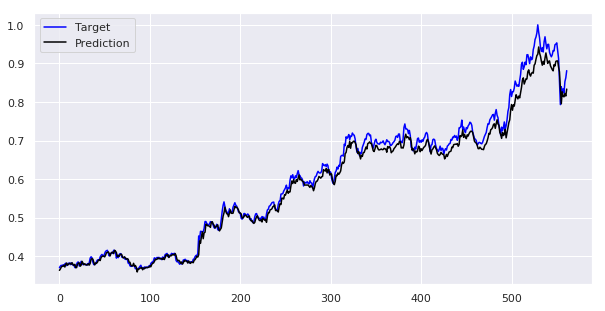

In [20]:
comp = pd.DataFrame({'Column1':y_test[:,3],'Column2':y_test_pred[:,3]})
plt.figure(figsize=(10,5))
plt.plot(comp['Column1'], color='blue', label='Target')
plt.plot(comp['Column2'], color='black', label='Prediction')
plt.legend()
plt.show()